In [1]:
import os.path
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
from astropy import wcs
from astropy.nddata import Cutout2D
from astropy import coordinates
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
import matplotlib.gridspec as gridspec
import aplpy
import pandas as pd
import numpy.ma as ma

In [2]:
part = 7
if part==0:
    from utilities import mergecatalogues

    mergecatalogues(criterion='brightest', pixel_width=20., arcsec_radius=1.)
    mergecatalogues(criterion='closest', pixel_width=20., arcsec_radius=1.)
    

In [3]:
if part==1:
    from utilities import magmagplot
    
    a = ['closest', 'brightest']
    b = ['b', 'i', 'v', 'z']
    c = ['1', '03']
    d = ['magnitude', 'flux'] #flux plots are fucked up
    for i in range(len(a)):
        for j in range(len(b)):
            for k in range(len(c)):
                magmagplot(criterion=a[i], band=b[j], separation=c[k], unit='magnitude')
    
    

In [4]:
if part==2:
    from utilities import pos_offset_plot
    pos_offset_plot()

In [5]:
if part == 3: #hardness ratio histogram
    path = '/Users/justin/Documents/Master_Thesis/data/catalogues/chandra_7ms/big_table.fits'
    cat = fits.open(path)[1].data
    hr = []
    hr_star = []
    hr_approx = []
    hr_false = []
    def f(i):
        return (cat.field('Hardness_Ratio')[i] != 0) & (cat.field('Hardness_Ratio_Err')[i] != 0) & (cat.field('Visual_Flag')[i] > 3)
    def g(i):
        return (cat.field('Hardness_Ratio')[i] != 0) & (cat.field('Hardness_Ratio_Err')[i] == 0) & (cat.field('Visual_Flag')[i] > 3)
    def h(i):
        return (cat.field('Hardness_Ratio')[i] == 0) & (cat.field('Hardness_Ratio_Err')[i] == 0) & (cat.field('Visual_Flag')[i] > 3)
    
    for i in range(len(cat)):
        if cat.field('Visual_Flag')[i] > 3:
            if (i==526) | (i==621) | (i==639) | (i==713):
                hr_star.append(cat.field('Hardness_Ratio')[i])
            elif (cat.field('Hardness_Ratio')[i] != 0) & (cat.field('Hardness_Ratio_Err')[i] != 0):
                hr.append(cat.field('Hardness_Ratio')[i])
            elif (cat.field('Hardness_Ratio')[i] != 0) & (cat.field('Hardness_Ratio_Err')[i] == 0):
                hr_approx.append(cat.field('Hardness_Ratio')[i])
            else:
                hr_false.append(cat.field('Hardness_Ratio')[i])  
                
    f=plt.figure()
    ax = f.add_subplot(111)
    #ax = plt.hist(cat.field('Hardness_Ratio'), 50, facecolor='blue', alpha=0.1)
    ax = plt.hist([hr_star, hr, hr_approx, hr_false], 30, range=(-1.,1.), color=['red', 'black', 'blue', 'white'], histtype='barstacked', alpha=1)
    #ax = plt.hist(hr, 50, range=(-1.,1.), facecolor='green', histtype='barstacked', alpha=0.5)
    plt.xlabel('Hardness Ratio')
    plt.ylabel('Number of sources')
    path = '/Users/justin/Documents/Master_Thesis/presentation/plots/hardness_ratio_histo.pdf'
    plt.savefig(path, format='pdf', dpi=1000,bbox_inches='tight')
    
    sc=[]
    hc=[]
    sce=[]
    hce=[]
    sc_best=[]
    hc_best=[]
    sce_best=[]
    hce_best=[]
    sc_star=[]
    hc_star=[]
    sce_star=[]
    hce_star=[]
    
    #def sth(s, hr=0.):
        #h=[]
        #for i in range(len(s)):
            #h.append(s[i]*(1+hr)/(1-hr))
        #return h
    
    #s_grid=np.zeros(100)
    #for i in range(len(s_grid)):
        #s_grid[i]=10**(-7 + i*(4)/100.)
    #h0=sth(s_grid,hr=0.)
    #h05=sth(s_grid,hr=0.5)
    #hn05=sth(s_grid,hr=-0.5)
    
    def f(S,H):
        hr=((10**H)-(10**S))/((10**H)+(10**S))
        return hr

    dS=0.1
    dH=0.1
    S, H = np.mgrid[slice(np.log10(2e-7), np.log10(3e-4) + dS, dS),
                    slice(np.log10(2e-7), np.log10(5e-4) + dH, dH)]
    hr=f(S,H)
    #hr = hr[:-1, :-1]
    hr_min, hr_max = hr.min(), hr.max()
    
    for i in range(len(cat)):
        if cat.field('Visual_Flag')[i] > 3:
            if (i==526) | (i==621) | (i==639) | (i==713):
                sc_star.append(np.log10(cat.field('Soft_Count')[i]))
                hc_star.append(np.log10(cat.field('Soft_Count')[i]*(1+cat.field('Hardness_Ratio')[i])/(1-cat.field('Hardness_Ratio')[i])))
                sce_star.append(np.log10(cat.field('Soft_Count_Err')[i]+cat.field('Soft_Count')[i])-np.log10(cat.field('Soft_Count')[i]))
                hce_star.append(0)
            elif (cat.field('Soft_Count_Err')[i] == -1) | (cat.field('Hard_Count_Err')[i] == -1):
                if cat.field('Soft_Count_Err')[i] == -1:
                    sc_best.append(np.log10(cat.field('Hard_Count')[i]*(1-cat.field('Hardness_Ratio')[i])/(1+cat.field('Hardness_Ratio')[i])))
                    sce_best.append(0)
                else:
                    sc_best.append(np.log10(cat.field('Soft_Count')[i]))
                    sce_best.append(np.log10(cat.field('Soft_Count_Err')[i]+cat.field('Soft_Count')[i])-np.log10(cat.field('Soft_Count')[i]))
                if cat.field('Hard_Count_Err')[i] == -1:
                    hc_best.append(np.log10(cat.field('Soft_Count')[i]*(1+cat.field('Hardness_Ratio')[i])/(1-cat.field('Hardness_Ratio')[i])))
                    hce_best.append(0)
                else:
                    hc_best.append(np.log10(cat.field('Hard_Count')[i]))
                    hce_best.append(np.log10(cat.field('Hard_Count_Err')[i]+cat.field('Hard_Count')[i])-np.log10(cat.field('Hard_Count')[i]))
            else:
                hc.append(np.log10(cat.field('Hard_Count')[i]))
                hce.append(np.log10(cat.field('Hard_Count_Err')[i]+cat.field('Hard_Count')[i])-np.log10(cat.field('Hard_Count')[i]))
                sc.append(np.log10(cat.field('Soft_Count')[i]))
                sce.append(np.log10(cat.field('Soft_Count_Err')[i]+cat.field('Soft_Count')[i])-np.log10(cat.field('Soft_Count')[i]))
                
    g=plt.figure(figsize=(4,4))
    ax=g.add_subplot(111)
    #ax.set_aspect('equal')
    plt.errorbar(sc, hc, xerr=sce, yerr=hce, ls='', fmt='.', ms=5, capsize=0.75, capthick=0.5, elinewidth=0.5, color='black')
    plt.errorbar(sc_best, hc_best, xerr=sce_best, yerr=hce_best, ls='', fmt='.', ms=5, capsize=0.75, capthick=0.5, elinewidth=0.5, color='blue')
    plt.errorbar(sc_star[0], hc_star[0], xerr=sce_star[0], yerr=hce_star[0], ls='', fmt='*', ms=7., capsize=0.75, capthick=0.5, elinewidth=0.5, color='red',label='527')
    plt.errorbar(sc_star[1], hc_star[1], xerr=sce_star[1], yerr=hce_star[1], ls='', fmt='o', ms=4.5, capsize=0.75, capthick=0.5, elinewidth=0.5, color='red',label='622')
    plt.errorbar(sc_star[2], hc_star[2], xerr=sce_star[2], yerr=hce_star[2], ls='', fmt='^', ms=5.5, capsize=0.75, capthick=0.5, elinewidth=0.5, color='red',label='640')
    plt.errorbar(sc_star[3], hc_star[3], xerr=sce_star[3], yerr=hce_star[3], ls='', fmt='v', ms=5.5, capsize=0.75, capthick=0.5, elinewidth=0.5, color='red',label='714') 
    #plt.plot(s_grid, h0, ls='--', lw=0.5, color='black')
    #plt.plot(s_grid, h05, ls='--', lw=0.5, color='black')
    #plt.plot(s_grid, hn05, ls='--', lw=0.5, color='black')
    #plt.pcolor(S, H, hr, cmap='RdBu',vmin=hr_min, vmax=hr_max, alpha=0.2)
    plt.axis([S.min(), S.max(), H.min(), H.max()])
    #plt.colorbar()
    CS = ax.contour(S, H, hr, [-0.5,0,0.5], colors='black',linestyles='dashdot')
    plt.clabel(CS, inline=1, fontsize=8, manual=[(-3.75,-4.25),(-3.75,-3.75),(-4.25,-3.75)], fmt='$\mathrm{HR}=%1.1f$')
    #plt.axis([np.log10(2e-7),np.log10(3e-4),np.log10(2e-7),np.log10(5e-4)])
    plt.xscale('linear')
    plt.yscale('linear')
    plt.xlabel('log(Soft band count rate)')
    plt.ylabel('log(Hard band count rate)')
    plt.legend(numpoints=1, ncol=2, frameon=False, loc='upper left', framealpha=0.5,fontsize='small')
    path = '/Users/justin/Documents/Master_Thesis/presentation/plots/hardness_ratio_plot.pdf'
    plt.savefig(path, format='pdf', dpi=1000,bbox_inches='tight')

In [6]:
if part == 4: #color-color diagrams
    larrow = 0.2
    path = '/Users/justin/Documents/Master_Thesis/data/catalogues/chandra_7ms/big_table.fits'
    cat = fits.open(path)[1].data
    B_V = np.full(cat.size, -99.)
    B_V_err = np.zeros(cat.size)
    V_z = np.full(cat.size, -99.)
    V_z_err = np.zeros(cat.size)
    V_i = np.full(cat.size, -99.)
    V_i_err = np.zeros(cat.size)
    i_z = np.full(cat.size, -99.)
    i_z_err = np.zeros(cat.size)
    B_V_arrowup = np.full(cat.size, -99.)
    V_z_arrowleft = np.full(cat.size, -99.)
    V_i_arrowup = np.full(cat.size, -99.)
    i_z_arrowleft = np.full(cat.size, -99.)
    B_V_arrowdown = np.full(cat.size, -99.)
    V_z_arrowright = np.full(cat.size, -99.)
    V_i_arrowdown = np.full(cat.size, -99.)
    i_z_arrowright = np.full(cat.size, -99.)
    B_V_star = np.full(cat.size, -99.)
    V_z_star = np.full(cat.size, -99.)
    V_i_star = np.full(cat.size, -99.)
    i_z_star = np.full(cat.size, -99.)
    V_i_star2 = np.full(cat.size, -99.)
    i_z_star2 = np.full(cat.size, -99.)
    flag1 = np.zeros(cat.size)
    flag2 = np.zeros(cat.size)
    flag3 = np.zeros(cat.size)
    flagz = np.zeros(cat.size)
    for i in range(cat.size):
        if cat.field('Visual_Flag')[i]>3:
            if (cat.field('GOODS_b_MagAper')[i] > 0) & (cat.field('GOODS_v_MagAper')[i] > 0):
                B_V[i] = cat.field('GOODS_b_MagAper')[i] - cat.field('GOODS_v_MagAper')[i]
                B_V_err[i] = (cat.field('GOODS_b_MagErrAper')[i]**2 + cat.field('GOODS_v_MagErrAper')[i]**2)**0.5
            if (cat.field('GOODS_b_MagAper')[i] > 0) & (cat.field('GOODS_v_MagAper')[i] == 0) & (cat.field('GOODS_v_MagErrAper')[i] > 0):
                B_V[i] = cat.field('GOODS_b_MagAper')[i] - cat.field('GOODS_v_MagErrAper')[i]
                B_V_arrowdown[i] = cat.field('GOODS_b_MagAper')[i] - cat.field('GOODS_v_MagErrAper')[i]
                B_V_err[i] = 0
            if (cat.field('GOODS_v_MagAper')[i] > 0) & (cat.field('GOODS_b_MagAper')[i] == 0) & (cat.field('GOODS_b_MagErrAper')[i] > 0):
                B_V[i] = cat.field('GOODS_b_MagErrAper')[i] - cat.field('GOODS_v_MagAper')[i]
                B_V_arrowup[i] = cat.field('GOODS_b_MagErrAper')[i] - cat.field('GOODS_v_MagAper')[i]
                B_V_err[i] = 0
            if (cat.field('GOODS_v_MagAper')[i] > 0) & (cat.field('GOODS_z_MagAper')[i] > 0):
                V_z[i] = cat.field('GOODS_v_MagAper')[i] - cat.field('GOODS_z_MagAper')[i]
                V_z_err[i] = (cat.field('GOODS_v_MagErrAper')[i]**2 + cat.field('GOODS_z_MagErrAper')[i]**2)**0.5
            if (cat.field('GOODS_v_MagAper')[i] > 0) & (cat.field('GOODS_z_MagAper')[i] == 0) & (cat.field('GOODS_z_MagErrAper')[i] > 0):
                V_z[i] = cat.field('GOODS_v_MagAper')[i] - cat.field('GOODS_z_MagErrAper')[i]
                V_z_arrowleft[i] = cat.field('GOODS_v_MagAper')[i] - cat.field('GOODS_z_MagErrAper')[i]
                V_z_err[i] = 0
            if (cat.field('GOODS_z_MagAper')[i] > 0) & (cat.field('GOODS_v_MagAper')[i] == 0) & (cat.field('GOODS_v_MagErrAper')[i] > 0):
                V_z[i] = cat.field('GOODS_v_MagErrAper')[i] - cat.field('GOODS_z_MagAper')[i]
                V_z_arrowright[i] = cat.field('GOODS_v_MagErrAper')[i] - cat.field('GOODS_z_MagAper')[i]
                V_z_err[i] = 0
            if (cat.field('GOODS_v_MagAper')[i] > 0) & (cat.field('GOODS_i_MagAper')[i] > 0):
                V_i[i] = cat.field('GOODS_v_MagAper')[i] - cat.field('GOODS_i_MagAper')[i]
                V_i_err[i] = (cat.field('GOODS_v_MagErrAper')[i]**2 + cat.field('GOODS_i_MagErrAper')[i]**2)**0.5
            if (cat.field('GOODS_v_MagAper')[i] > 0) & (cat.field('GOODS_i_MagAper')[i] == 0) & (cat.field('GOODS_i_MagErrAper')[i] > 0):
                V_i[i] = cat.field('GOODS_v_MagAper')[i] - cat.field('GOODS_i_MagErrAper')[i]
                V_i_arrowdown[i] = cat.field('GOODS_v_MagAper')[i] - cat.field('GOODS_i_MagErrAper')[i]
                V_i_err[i] = 0
            if (cat.field('GOODS_i_MagAper')[i] > 0) & (cat.field('GOODS_v_MagAper')[i] == 0) & (cat.field('GOODS_v_MagErrAper')[i] > 0):
                V_i[i] = cat.field('GOODS_v_MagErrAper')[i] - cat.field('GOODS_i_MagAper')[i] 
                V_i_arrowup[i] = cat.field('GOODS_v_MagErrAper')[i] - cat.field('GOODS_i_MagAper')[i]
                V_i_err[i] = 0
            if (cat.field('GOODS_i_MagAper')[i] > 0) & (cat.field('GOODS_z_MagAper')[i] > 0):
                i_z[i] = cat.field('GOODS_i_MagAper')[i] - cat.field('GOODS_z_MagAper')[i]
                i_z_err[i] = (cat.field('GOODS_i_MagErrAper')[i]**2 + cat.field('GOODS_z_MagErrAper')[i]**2)**0.5
            if (cat.field('GOODS_i_MagAper')[i] > 0) & (cat.field('GOODS_z_MagAper')[i] == 0) & (cat.field('GOODS_z_MagErrAper')[i] > 0):
                i_z[i] = cat.field('GOODS_i_MagAper')[i] - cat.field('GOODS_z_MagErrAper')[i]
                i_z_arrowleft[i] = cat.field('GOODS_i_MagAper')[i] - cat.field('GOODS_z_MagErrAper')[i]
                i_z_err[i] = 0
            if (cat.field('GOODS_z_MagAper')[i] > 0) & (cat.field('GOODS_i_MagAper')[i] == 0) & (cat.field('GOODS_i_MagErrAper')[i] > 0):
                i_z[i] = cat.field('GOODS_i_MagErrAper')[i] - cat.field('GOODS_z_MagAper')[i] 
                i_z_arrowright[i] = cat.field('GOODS_i_MagErrAper')[i] - cat.field('GOODS_z_MagAper')[i] 
                i_z_err[i] = 0
            if (B_V[i]!=-99) & (V_z[i]!=-99):
                if (B_V[i] > 1.1 + V_z[i]) & (B_V[i] > 1.1) & (V_z[i] < 1.6):
                    flag1[i]=1
                    flagz[i]+=4
                    B_V_star[i]=B_V[i]
                    V_z_star[i]=V_z[i]
                elif (B_V_arrowup[i]!=-99) | (V_z_arrowleft[i]!=-99):
                    if ((B_V_arrowup[i]!=-99) & (V_z[i] < 1.6)) | ((V_z_arrowleft[i]!=-99) & (B_V[i] > 1.1)) | ((B_V_arrowup[i]!=-99) & (V_z_arrowleft[i]!=-99)):
                        flag1[i]=2
                        flagz[i]+=4
                        B_V_star[i]=B_V[i]
                        V_z_star[i]=V_z[i]
            if (V_i[i]!=-99) & (i_z[i]!=-99):
                if ((V_i[i] > 1.5 + (0.9*i_z[i])) | (V_i[i] > 2.)) & (V_i[i] > 1.2) & (i_z[i] < 1.3) & (cat.field('GOODS_b_FluxAper')[i]/cat.field('GOODS_b_FluxErrAper')[i] < 2.):
                    flag2[i]=1
                    flagz[i]+=5
                    V_i_star[i]=V_i[i]
                    i_z_star[i]=i_z[i]
                elif (V_i_arrowup[i]!=-99) | (i_z_arrowleft[i]!=-99):
                    if ((V_i_arrowup[i]!=-99) & (i_z[i] < 1.3) & (cat.field('GOODS_b_FluxAper')[i]/cat.field('GOODS_b_FluxErrAper')[i] < 2.)) | ((i_z_arrowleft[i]!=-99) & (V_i[i] > 1.2) & (cat.field('GOODS_b_FluxAper')[i]/cat.field('GOODS_b_FluxErrAper')[i] < 2.)) | ((V_i_arrowup[i]!=-99) & (i_z_arrowleft[i]!=-99) & (cat.field('GOODS_b_FluxAper')[i]/cat.field('GOODS_b_FluxErrAper')[i] < 2.)):
                        flag2[i]=2
                        flagz[i]+=5
                        V_i_star[i]=V_i[i]
                        i_z_star[i]=i_z[i]
            if (V_i[i]!=-99) & (i_z[i]!=-99):
                if (i_z[i] > 1.3) & ((cat.field('GOODS_b_FluxAper')[i]/cat.field('GOODS_b_FluxErrAper')[i] < 2.) | (cat.field('GOODS_v_FluxAper')[i]/cat.field('GOODS_v_FluxErrAper')[i] < 2.)):
                    flag3[i]=1
                    flagz[i]+=6
                    V_i_star2[i]=V_i[i]
                    i_z_star2[i]=i_z[i]
                elif (i_z_arrowright[i]!=-99):
                    if ((cat.field('GOODS_b_FluxAper')[i]/cat.field('GOODS_b_FluxErrAper')[i] < 2.) | (cat.field('GOODS_v_FluxAper')[i]/cat.field('GOODS_v_FluxErrAper')[i] < 2.)):
                        flag3[i]=2
                        flagz[i]+=6
                        V_i_star2[i]=V_i[i]
                        i_z_star2[i]=i_z[i]
            if flagz[i]>6:
                flagz[i]=-1
    r, g, b = 0,0,0
    marktype=['^','v','s','h','p','o','<','>']
    marksize=[6,6,5,6,6,6,6,6]
    f = plt.figure()
    ax = f.add_subplot(111)
    ax.errorbar(V_z, B_V, xerr=V_z_err, yerr=B_V_err, color='lightgray', capsize=0.5, capthick=0.5, elinewidth=0.5, ls='')
    ax.plot(V_z, B_V, color='black', marker='.', ls='', ms=5)
    col_n=0
    for i in range(cat.size):
        lab = str(i+1)
        if flag1[i]==1:
            ax.errorbar(V_z_star[i], B_V_star[i], xerr=V_z_err[i], yerr=B_V_err[i], capsize=0.5, capthick=0.5, elinewidth=0.5, color='lightgray', ls='')
            hnew = ax.plot(V_z_star[i], B_V_star[i], color='black', marker='*', ls='', ms=8, label=lab)
        if flag1[i]==2:
            col_n += 1
            r = (np.sin((np.pi*2/3)+(col_n*0.06*np.pi))+1)/2
            b = (np.sin((np.pi*4/3)+(col_n*0.06*np.pi))+1)/2
            g = (np.sin((np.pi*6/3)+(col_n*0.06*np.pi))+1)/2
            ax.errorbar(V_z_star[i], B_V_star[i], xerr=V_z_err[i], yerr=B_V_err[i], capsize=0.5, capthick=0.5, elinewidth=0.5, color='lightgray', ls='')
            hnew = ax.plot(V_z_star[i], B_V_star[i], color=(r,g,b), marker=marktype[col_n%8], ls='', ms=marksize[col_n%8], label=lab)
        if V_z_arrowright[i]!=-99:
            ax.arrow(V_z_arrowright[i], B_V[i], 0.25, 0., head_width=0.04, head_length=0.04, fc='k', ec='k', lw=0.5)
        if V_z_arrowleft[i]!=-99:
            ax.arrow(V_z_arrowleft[i], B_V[i], -0.25, 0., head_width=0.04, head_length=0.04, fc='k', ec='k', lw=0.5)
        if B_V_arrowup[i]!=-99:
            ax.arrow(V_z[i], B_V_arrowup[i], 0., 0.25, head_width=0.04, head_length=0.04, fc='k', ec='k', lw=0.5)
        if B_V_arrowdown[i]!=-99:
            ax.arrow(V_z[i], B_V_arrowdown[i], 0., -0.25, head_width=0.04, head_length=0.04, fc='k', ec='k', lw=0.5)
    plt.axis([-0.5,3,-1.5,3])
    plt.fill_between([-3,0,1.6],7,[1.1,1.1,2.7], color='grey', alpha=0.2, lw=0.2)
    ax.plot([-3,0,1.6,1.6], [1.1,1.1,1.1+1.6,7], color='black', lw=0.5)
    ax.set_aspect(3.5/4.5)
    plt.legend(ncol=2,numpoints=1,fontsize=7,loc='lower right', bbox_to_anchor=(1.45, 0.1))       
    plt.xlabel('$\mathrm{(V-z)}_\mathrm{AB}$', size=13)
    plt.ylabel('$\mathrm{(B-V)}_\mathrm{AB}$', size=13)
    plt.text(s='$z\sim4$',x=0,y=2.5, fontsize=15)
    path = '/Users/justin/Documents/Master_Thesis/presentation/plots/color_color_diagrams/B_dropouts.pdf'
    plt.savefig(path, format='pdf', dpi=1000,bbox_inches='tight')
    
    f3 = plt.figure()
    ax3 = f3.add_subplot(111)
    ax3.errorbar(i_z, V_i, xerr=i_z_err, yerr=V_i_err,capsize=0.5, capthick=0.5, elinewidth=0.5, color='lightgray', ls='')
    ax3.plot(i_z, V_i, color='black', marker='.', ls='', ms=5)
    col_n=0
    for i in range(cat.size):
        lab = str(i+1)
        if flag2[i]==1:
            ax3.errorbar(i_z_star[i], V_i_star[i], capsize=0.5, capthick=0.5, elinewidth=0.5, xerr=i_z_err[i], yerr=V_i_err[i], color='lightgray', ls='')
            hnew = ax3.plot(i_z_star[i], V_i_star[i], color='black', marker='*', ls='', ms=8, label=lab)
        if flag2[i]==2:
            col_n += 1
            r = (np.sin((np.pi*2/3)+(col_n*0.12*np.pi))+1)/2
            b = (np.sin((np.pi*4/3)+(col_n*0.12*np.pi))+1)/2
            g = (np.sin((np.pi*6/3)+(col_n*0.12*np.pi))+1)/2
            ax3.errorbar(i_z_star[i], V_i_star[i], xerr=i_z_err[i], yerr=V_i_err[i], capsize=0.5, capthick=0.5, elinewidth=0.5, color='lightgray', ls='')
            hnew = ax3.plot(i_z_star[i], V_i_star[i], color=(r,g,b), marker=marktype[col_n%8], ls='', ms=marksize[col_n%8], label=lab)
        if i_z_arrowright[i]!=-99:
            ax3.arrow(i_z_arrowright[i], V_i[i], 0.25, 0., head_width=0.04, head_length=0.04, fc='k', ec='k', lw=0.5)
        if i_z_arrowleft[i]!=-99:
            ax3.arrow(i_z_arrowleft[i], V_i[i], -0.25, 0., head_width=0.04, head_length=0.04, fc='k', ec='k', lw=0.5)
        if V_i_arrowup[i]!=-99:
            ax3.arrow(i_z[i], V_i_arrowup[i], 0., 0.25, head_width=0.04, head_length=0.04, fc='k', ec='k', lw=0.5)
        if V_i_arrowdown[i]!=-99:
            ax3.arrow(i_z[i], V_i_arrowdown[i], 0., -0.25, head_width=0.04, head_length=0.04, fc='k', ec='k', lw=0.5)
    plt.axis([-1.,2.,-1,2.5])
    plt.fill_between([-2.5,-0.3/0.9,0.5/0.9,1.3],4,[1.2,1.2,2,2], color='grey', alpha=0.2, lw=0.2)
    ax3.plot([-2.5,-0.3/0.9,0.5/0.9,1.3,1.3], [1.2,1.2,2,2,4], color='black', lw=0.5)
    ax3.set_aspect(3./3.5)
    plt.legend(ncol=2,numpoints=1,fontsize=7,loc='lower right', bbox_to_anchor=(1.45, 0.25)) 
    plt.xlabel('$\mathrm{(i-z)}_\mathrm{AB}$', size=13)
    plt.ylabel('$\mathrm{(V-i)}_\mathrm{AB}$', size=13)
    plt.text(s='$z\sim5$',x=-0.1,y=2.1, fontsize=15)
    path = '/Users/justin/Documents/Master_Thesis/presentation/plots/color_color_diagrams/V_dropouts.pdf'
    plt.savefig(path, format='pdf', dpi=1000,bbox_inches='tight')
    
    f2 = plt.figure()
    ax2 = f2.add_subplot(111)
    ax2.errorbar(i_z, V_i, xerr=i_z_err, yerr=V_i_err, capsize=0.5, capthick=0.5, elinewidth=0.5, color='lightgray', ls='')
    ax2.plot(i_z, V_i, color='black', marker='.', ls='', ms=5)
    col_n=0
    for i in range(cat.size):
        lab = str(i+1)
        if flag3[i]==1:
            ax2.errorbar(i_z_star2[i], V_i_star2[i], xerr=i_z_err[i], yerr=V_i_err[i], capsize=0.5, capthick=0.5, elinewidth=0.5, color='lightgray', ls='')
            hnew = ax2.plot(i_z_star2[i], V_i_star2[i], color='black', marker='*', ls='', ms=8, label=lab)
        if flag3[i]==2:
            col_n += 1
            r = (np.sin((np.pi*2/3)+(col_n*0.6*np.pi))+1)/2
            b = (np.sin((np.pi*4/3)+(col_n*0.6*np.pi))+1)/2
            g = (np.sin((np.pi*6/3)+(col_n*0.6*np.pi))+1)/2
            ax2.errorbar(i_z_star2[i], V_i_star2[i], xerr=i_z_err[i], yerr=V_i_err[i], capsize=0.5, capthick=0.5, elinewidth=0.5, color='lightgray', ls='')
            hnew = ax2.plot(i_z_star2[i], V_i_star2[i], color=(r,g,b), marker=marktype[col_n%8], ls='', ms=marksize[col_n%8], label=lab)
        if i_z_arrowright[i]!=-99:
            ax2.arrow(i_z_arrowright[i], V_i[i], 0.25, 0., head_width=0.04, head_length=0.04, fc='k', ec='k', lw=0.5)
        if i_z_arrowleft[i]!=-99:
            ax2.arrow(i_z_arrowleft[i], V_i[i], -0.25, 0., head_width=0.04, head_length=0.04, fc='k', ec='k', lw=0.5)
        if V_i_arrowup[i]!=-99:
            ax2.arrow(i_z[i], V_i_arrowup[i], 0., 0.25, head_width=0.04, head_length=0.04, fc='k', ec='k', lw=0.5)
        if V_i_arrowdown[i]!=-99:
            ax2.arrow(i_z[i], V_i_arrowdown[i], 0., -0.25, head_width=0.04, head_length=0.04, fc='k', ec='k', lw=0.5)
    plt.axis([-1.,2.,-1,2.5])
    plt.fill_between([1.3,4],4,-2.5, color='grey', alpha=0.2, lw=0.2)
    ax2.plot([1.3,1.3], [-2.5,4], color='black', lw=0.5)
    ax2.set_aspect(3./3.5)
    plt.legend(ncol=2,numpoints=1,fontsize=7,loc='lower right', bbox_to_anchor=(1.45, 0.4)) 
    plt.xlabel('$\mathrm{(i-z)}_\mathrm{AB}$', size=13)
    plt.ylabel('$\mathrm{(V-i)}_\mathrm{AB}$', size=13)
    plt.text(s='$z\sim6$',x=1.4,y=2.1, fontsize=15)
    path = '/Users/justin/Documents/Master_Thesis/presentation/plots/color_color_diagrams/i_dropouts.pdf'
    plt.savefig(path, format='pdf', dpi=1000,bbox_inches='tight')
    
    
    

In [7]:
if part == 5: #goods f(lambda) plots for each source (later add other filters)
    from utilities import sed_plot
    sed_plot()



In [8]:
if part == 6: #flux comparison with goods z catalogue
    search_radius = 0.2 #arcsec
    goods_aper_pix = [2.93,4.17,5.87,8.33,11.77,16.67,23.57,33.33,47.13,66.67,94.27]
    goods_aper = np.zeros(len(goods_aper_pix))
    for i in range(len(goods_aper_pix)):
        goods_aper[i] = goods_aper_pix[i] * 0.03 #diameter arcsec
    path='/Users/justin/Documents/Master_Thesis/data/catalogues/chandra_7ms/big_table.fits'
    cat = fits.open(path)[1].data
    path='/Users/justin/Documents/Master_Thesis/data/catalogues/goods/h_goods_sz_r2.0z_cat_nohdr.txt'
    t1 = pd.read_csv(path, delim_whitespace=True, header=None)
    goods_m = []
    goods_me = []
    se_m = []
    se_me = []
    for i in range(len(cat)):
        if (cat.field('GOODS_z_FluxAper')[i] > 0):
            n = -1
            radius = ((cat.field('GOODS_z_RA')[i]-t1[1]).pow(2)+(cat.field('GOODS_z_Dec')[i]-t1[2]).pow(2)).pow(0.5)
            for j in range(len(t1)):
                if radius[j] < search_radius / 3600.:
                    if n == -1:
                        n = j
                    else:
                        if radius[j] < radius[n]: #closest
                            n = j
            if n != -1:
                m = -1
                aper_diff = np.zeros(len(goods_aper))
                for k in range(len(goods_aper)):
                    aper_diff[k] = abs(cat.field('Aperture')[i]-goods_aper[k])
                for k in range(len(goods_aper)):
                    if aper_diff[k] == min(aper_diff):
                        m = k
                goods_m.append(t1[49+m][n])
                goods_me.append(t1[60+m][n])
                se_m.append(cat.field('GOODS_z_MagAper')[i])
                se_me.append(cat.field('GOODS_z_MagErrAper')[i])
                if abs(t1[49+m][n] - cat.field('GOODS_z_MagAper')[i]) > 0.5:
                    print(i, n, m)
            else:
                pass
           
        
# 1    ID_IAU
# 2    ALPHA_J2000
# 3    DELTA_J2000
# 4    SECT_REFNUM
# 5    X_SECT
# 6    Y_SECT
# 7    X_MOSAIC
# 8    Y_MOSAIC
# 9    XPEAK_MOSAIC
# 10   YPEAK_MOSAIC
# 11   XPEAK_WORLD
# 12   YPEAK_WORLD
# 13   XMIN_MOSAIC
# 14   YMIN_MOSAIC
# 15   XMAX_MOSAIC
# 16   YMAX_MOSAIC
# 17   ISOAREAF_IMAGE
# 18   ISOAREA_IMAGE
# 19   THETA_IMAGE
# 20   ELLIPTICITY
# 21   ELONGATION
# 22   ERRTHETA_IMAGE
# 23   KRON_RADIUS
# 24   FLUX_RADIUS
# 27   FWHM_IMAGE
# 28   CLASS_STAR
# 29   FLAGS
# 30   IMAFLAGS_ISO
# 31   NIMAFLAGS_ISO
# 32   BACKGROUND
# 33   FLUX_MAX
# 34   MAG_ISO
# 35   MAGERR_ISO
# 36   FLUX_ISO
# 37   FLUXERR_ISO
# 38   MAG_ISOCOR
# 39   MAGERR_ISOCOR
# 40   FLUX_ISOCOR
# 41   FLUXERR_ISOCOR
# 42   MAG_AUTO
# 43   MAGERR_AUTO
# 44   FLUX_AUTO
# 45   FLUXERR_AUTO
# 46   MAG_BEST
# 47   MAGERR_BEST
# 48   FLUX_BEST
# 49   FLUXERR_BEST
# 50   MAG_APER
# 61   MAGERR_APER
# 72   FLUX_APER
# 83   FLUXERR_APER
# 94   X2_IMAGE
# 95   Y2_IMAGE
# 96   XY_IMAGE
# 97   ERRX2_IMAGE
# 98   ERRY2_IMAGE
# 99   ERRXY_IMAGE
# 100  A_IMAGE
# 101  B_IMAGE
# 102  ERRA_IMAGE
# 103  ERRB_IMAGE
# 104  ID_MOSAIC

    

In [9]:
if part == 6:
    f = plt.figure()
    ax = f.add_subplot(111)
    plt.errorbar(se_m, goods_m, xerr=se_me, yerr=goods_me, ls='', capsize=0.75, capthick=0.5, elinewidth=0.5, color='blue')
    ax.plot(se_m, goods_m, marker='.', ms=3.5, ls='', color='red')
    x0,x1 = ax.get_xlim()
    y0,y1 = ax.get_ylim()
    z0 = min(x0, y0)
    z1 = max(x1, y1)
    ax.plot([z0, z1], [z0, z1], color='black', marker='', ls='-', lw=0.3)
    plt.axis([z0, z1, z0, z1])
    ax.set_aspect(1)
    plt.ylabel('Mag$_\mathrm{GOODS}$')
    plt.xlabel('Mag$_\mathrm{This\,work}$')
    path = '/Users/justin/Documents/Master_Thesis/presentation/plots/goods_mag/goods_z_new.pdf'
    plt.savefig(path, format='pdf', dpi=1000,bbox_inches='tight')
    plt.clf()
    
    f = plt.figure()
    ax = f.add_subplot(111)
    ax.plot(se_me, goods_me, marker='.', ms=3.5, ls='', color='blue')
    x0,x1 = ax.get_xlim()
    y0,y1 = ax.get_ylim()
    z0 = min(x0, y0)
    z1 = max(x1, y1)
    ax.plot([z0, z1], [z0, z1], color='black', marker='', ls='-', lw=0.3)
    plt.axis([z0, z1, z0, z1])
    ax.set_aspect(1)
    plt.ylabel('$\Delta$Mag$_\mathrm{GOODS}$')
    plt.xlabel('$\Delta$Mag$_\mathrm{This\,work}$')
    path = '/Users/justin/Documents/Master_Thesis/presentation/plots/goods_mag/goods_z_err_new.pdf'
    plt.savefig(path, format='pdf', dpi=1000,bbox_inches='tight')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


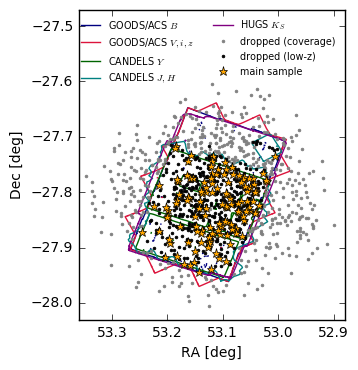

In [20]:
if part == 7:
    path = '/Users/justin/Documents/Master_Thesis/data/catalogues/chandra_7ms/big_table.fits'
    cat = fits.open(path)[1].data
    mask1=np.ones(len(cat))
    mask2=np.ones(len(cat))
    mask3=np.ones(len(cat))
    ra1=[]
    dec1=[]
    ra2=[]
    dec2=[]
    ra3=[]
    dec3=[]
    for i in range(len(cat)):
        if cat.field('Visual_Flag')[i]<2:
            mask1[i]=0
            ra1.append(cat.field('RA')[i])
            dec1.append(cat.field('DEC')[i])
        elif cat.field('Visual_Flag')[i]==2:
            mask2[i]=0
            ra2.append(cat.field('RA')[i])
            dec2.append(cat.field('DEC')[i])
        else:
            mask3[i]=0
            ra3.append(cat.field('RA')[i])
            dec3.append(cat.field('DEC')[i])
            
    cont_list = ['b11','b12','b13','b14','b21','b24','b25','b31','b32','b35','b42','b43','b44','b45','z11','z12','z13','z14','z21','z24','z25','z31','z32','z35','z42','z43','z44','z45','105', '125+160', 'hugs']
    cont=[]
    n=0
    temp_ra=[]
    temp_dec=[]
    f=plt.figure()
    ax=f.add_subplot(111)
    for i in range(len(cont_list)):
        n=0
        print(i)
        path='/Users/justin/Documents/Master_Thesis/data/catalogues/chandra_7ms/contour_' + cont_list[i] + '.con'
        cont.append(pd.read_csv(path, delim_whitespace=True, header=None))
        temp_ra[:] = []
        temp_dec[:] = []
        for j in range(len(cont[i][0])-1):
            if ((cont[i][0][j+1]-cont[i][0][j])**2. + (cont[i][1][j+1]-cont[i][1][j])**2.)**0.5 < 0.001:
                if j%20 == 0:
                    temp_ra.append(cont[i][0][j])
                    temp_dec.append(cont[i][1][j])
            else:
                temp_ra.append(cont[i][0][j])
                temp_dec.append(cont[i][1][j])
                
                if (n==0) & (i == 0):
                    plt.plot(temp_ra,temp_dec,ls='-', lw=1., marker='',color='navy', label='GOODS/ACS $B$')
                elif (n==0) & (i == 14):
                    plt.plot(temp_ra,temp_dec,ls='-', lw=1.,marker='',color='crimson', label='GOODS/ACS $V,i,z$')
                elif (n==0) & (i == 28):
                    plt.plot(temp_ra,temp_dec,ls='-', lw=1.,marker='',color='darkgreen', label='CANDELS $Y$')
                elif (n==0) & (i == 29):
                    plt.plot(temp_ra,temp_dec,ls='-', lw=1.,marker='',color='teal', label='CANDELS $J,H$')
                elif (n==0) & (i == 30):
                    plt.plot(temp_ra,temp_dec,ls='-', lw=1.,marker='',color='purple', label='HUGS $K_S$')
                elif i < 14:
                    plt.plot(temp_ra,temp_dec,ls='-', lw=1., marker='',color='navy')
                elif i < 28:
                    plt.plot(temp_ra,temp_dec,ls='-', lw=1.,marker='',color='crimson')
                elif i == 28:
                    plt.plot(temp_ra,temp_dec,ls='-', lw=1.,marker='',color='darkgreen')
                elif i == 29:
                    plt.plot(temp_ra,temp_dec,ls='-', lw=1.,marker='',color='teal')
                elif i == 30:
                    plt.plot(temp_ra,temp_dec,ls='-', lw=1.,marker='',color='purple')
                temp_ra[:] = []
                temp_dec[:] = []
                n += 1
    plt.plot(ra1, dec1 ,ls='',marker='.', ms=4., color='gray', label='dropped (coverage)')
    plt.plot(ra2, dec2 ,ls='',marker='.', ms=4.,color='black', label='dropped (low-z)')
    plt.plot(ra3, dec3 ,ls='',marker='*', ms=6.5,color='orange', label='main sample')
    plt.axis([52.88, 53.36, -28.03,-27.47])
    ax.set_aspect((-52.88+53.36)/(28.03-27.55))
    plt.gca().invert_xaxis()
    plt.xlabel('RA [deg]')
    plt.ylabel('Dec [deg]')
    plt.legend(ncol=2, frameon=False, numpoints=1, framealpha=0.5, mode='extend',fontsize='x-small')
    path = '/Users/justin/Documents/Master_Thesis/presentation/plots/chandra_field_final_python.pdf'
    plt.savefig(path, format='pdf', dpi=1000,bbox_inches='tight')